# 7장. 시계열 데이터를 다뤄보자.
- 웹 트래픽, 주식같은 데이터를 예측할 때
- 원 데이터의 안정성을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 필요하다.
- fbprophet라는 모듈(페이스북에서 만듬) > Visual C++ Build Tools 설치 > pip install pystan / pip install prophet

#### Prophet
- 페이스북이 만든 시계열 예측 라이브러리
- 통계적 지식이 없어도 직관적 파라미터를 통해 모형을 조정할 수 있음
- 일반적인 경우 기본값만 사용해도 높은 성능을 보여줌
- Python, R로 사용 가능

## Numpy의 polyfit으로 회귀(regression) 분석하기
- 회귀 : 데이터를 간단한 모델로 표현하고 싶다는 뜻

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [5]:
path = "c:/Windows/Fonts/malgun.ttf"
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

In [8]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv', 
                                          encoding='utf-8', thousands=',',
                                          names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


- 2016년 7월 1일 ~ 2017년 6월 16일까지 유입량

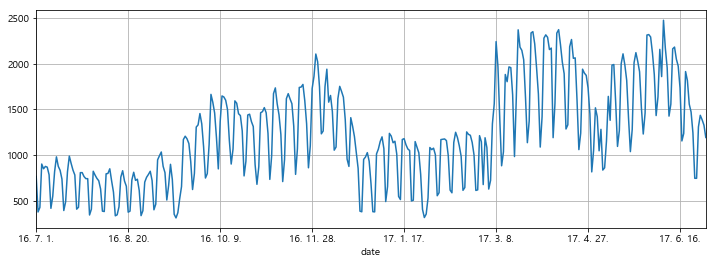

In [9]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True)

In [11]:
# 정확한 주기성 확인하고 싶다
'''
time : 시간축
traffic : 웹 트래픽 자료 

'''
time = np.arange(0,len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

In [12]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

polyfit : numpy의 명령어 중 하나. 직선을 만드는 역할을 한다.
 => polyfit(x축, y축, 1)

linspace : x축 데이터
 => linspace(시작점, 끝점, 간격?)
 
poly1d : y축 데이터
 => poly1d({polyfit data})

In [14]:
# 1차, 2차, 3차, 15차 함수로 표현
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.53280466762925
330.4777304274343


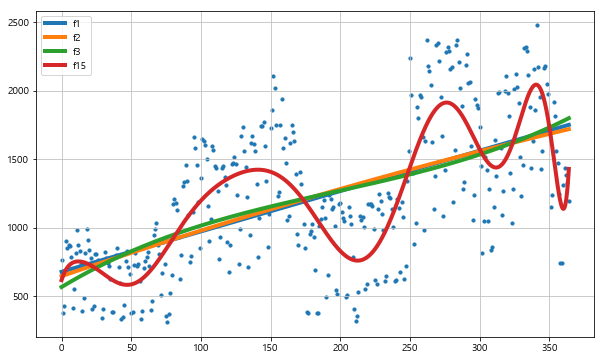

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

## Prophet 모듈을 이용한 forecast 예측

In [42]:
# 코드[3]에서 받은 pinkwink_web에서 index(날짜)와 hit(방문수)만 저장

df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


m = Prophet() : prophet 객체 생성

m.fit(); : 저장

- 객체는 한번만 fit 할 수 있다. 여러 개를 fit하려면 여러 개의 객체를 생성해야 한다.

In [43]:
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [44]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,908.312485,697.284618,1125.964004
421,2017-08-26,493.269868,288.647427,721.960595
422,2017-08-27,625.855539,413.676538,839.138197
423,2017-08-28,1178.497203,970.403641,1390.063636
424,2017-08-29,1214.444999,989.043634,1419.409474


make_future_dataframe(주기) : 데이터 이후 약 '주기' 이후의 미래 데이터 프레임 생성

predict : 예측

yhat_lower, yhat_upper 같이 범위로 제공

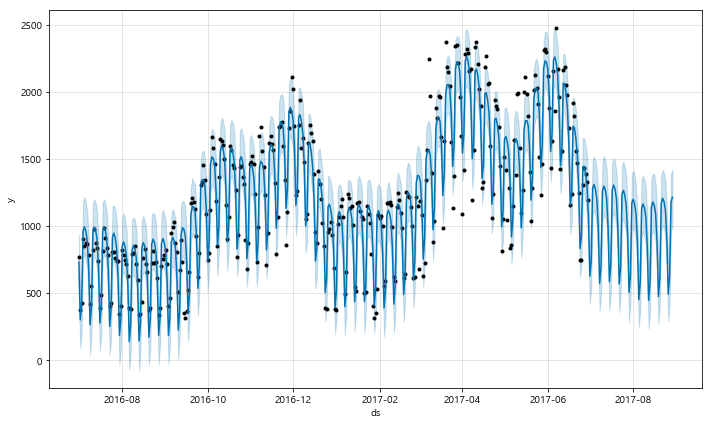

In [51]:
m.plot(forecast);

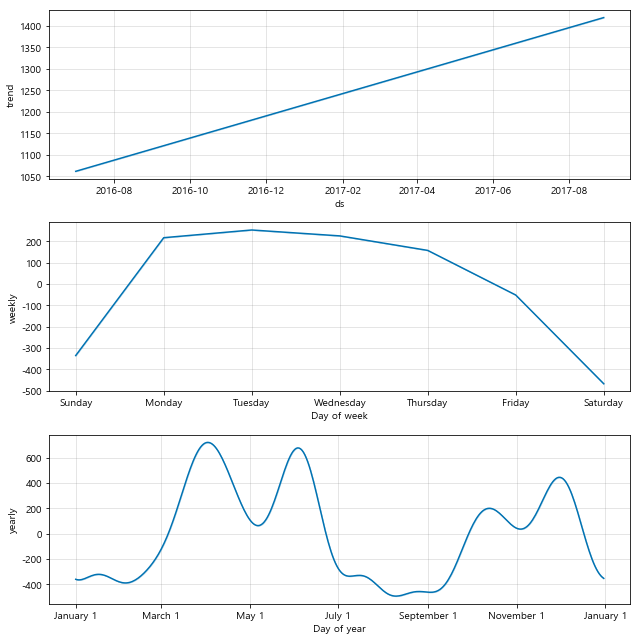

In [52]:
# trend : 전체적인 경향은 직선
# weekly : 주간
# yearly : 연간

m.plot_components(forecast);

## seasonal 시계열 분석으로 주식 데이터 분석하기

In [8]:
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

start_date = '2010-03-01' 
end_date = '2018-02-28' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
    
# KIA = web.DataReader('KRX:000270','google',start,end) # 구글용... 동작이 안됨
# KIA = web.DataReader('000270.KS','yahoo',start,end) # 구글용... 동작이 안됨
KIA.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-03-02,22050.0,22300.0,21800.0,21850.0,21850.0,3935516
2010-03-03,22100.0,22450.0,21850.0,22400.0,22400.0,4380617
2010-03-04,22400.0,22600.0,22300.0,22500.0,22500.0,2490087
2010-03-05,22500.0,22750.0,22350.0,22750.0,22750.0,2379282
2010-03-08,23050.0,23100.0,22500.0,22800.0,22800.0,4326618


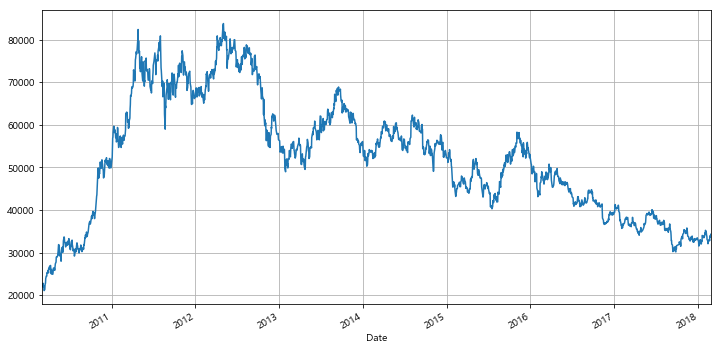

In [57]:
KIA['Close'].plot(figsize=(12,6), grid=True);

In [10]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-03-02,22050.0,22300.0,21800.0,21850.0,21850.0,3935516
2010-03-03,22100.0,22450.0,21850.0,22400.0,22400.0,4380617
2010-03-04,22400.0,22600.0,22300.0,22500.0,22500.0,2490087
2010-03-05,22500.0,22750.0,22350.0,22750.0,22750.0,2379282
2010-03-08,23050.0,23100.0,22500.0,22800.0,22800.0,4326618
2010-03-09,22550.0,22650.0,22050.0,22050.0,22050.0,4707240
2010-03-10,22200.0,22250.0,21750.0,22200.0,22200.0,4146645
2010-03-11,22200.0,22350.0,21750.0,21800.0,21800.0,3833839
2010-03-12,21800.0,21900.0,21100.0,21100.0,21100.0,6123788


In [13]:
KIA_trunc.Date

AttributeError: 'DataFrame' object has no attribute 'Date'

In [59]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2010-03-02,21850.0
1,2010-03-03,22400.0
2,2010-03-04,22500.0
3,2010-03-05,22750.0
4,2010-03-08,22800.0


In [60]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [61]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2055,2017-12-25
2056,2017-12-26
2057,2017-12-27
2058,2017-12-28
2059,2017-12-29


In [62]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2055,2017-12-25,32047.485379,14069.724311,50159.885727
2056,2017-12-26,32114.406591,14871.918696,50057.945358
2057,2017-12-27,32034.601373,14430.484540,49750.480322
2058,2017-12-28,31939.448822,14291.678489,50897.039712
2059,2017-12-29,31814.846771,14044.076170,49975.902362


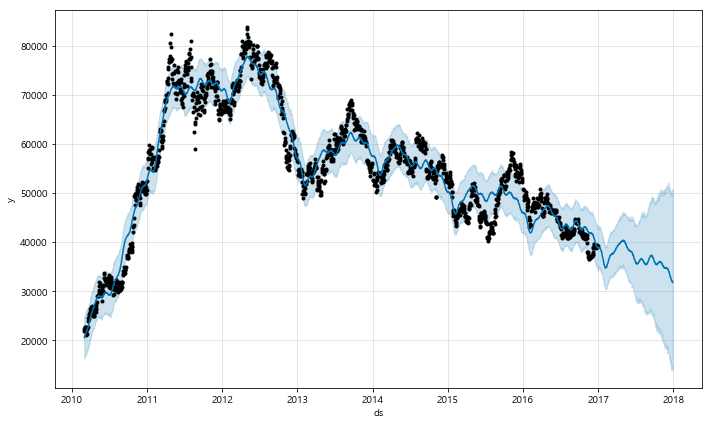

In [63]:
m.plot(forecast);

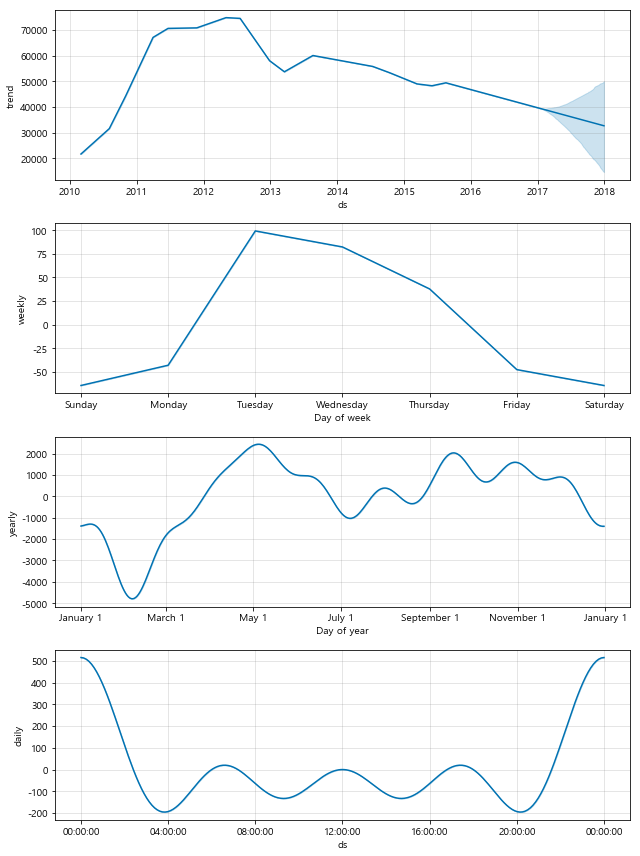

In [64]:
m.plot_components(forecast);

[*********************100%***********************]  1 of 1 downloaded


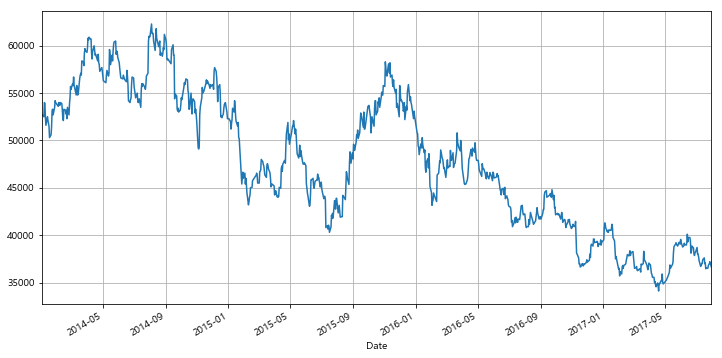

In [66]:
# 데이터 받아옴
start_date = '2014-1-1' 
end_date = '2017-7-31' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA['Close'].plot(figsize=(12,6), grid=True);

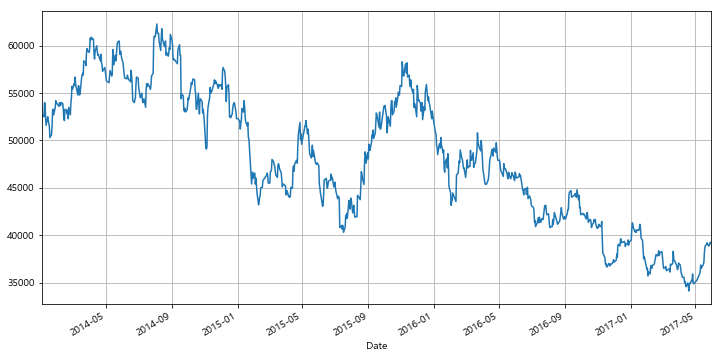

In [68]:
# 예측용 데이터
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True);

In [69]:
# 예측용 데이터로 데이터프레임 만듬
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

In [70]:
m = Prophet(daily_seasonality=True)
m.fit(df);

In [71]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


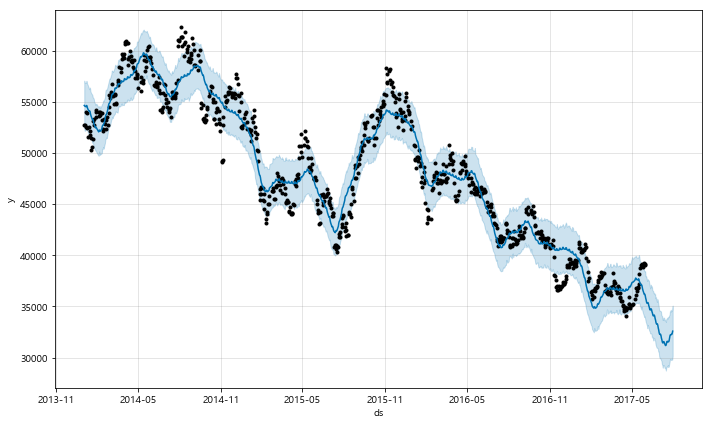

In [72]:
forecast = m.predict(future)
m.plot(forecast);

위의 예측용 데이터와 이후 60일의 실제 데이터를 비교해보자.

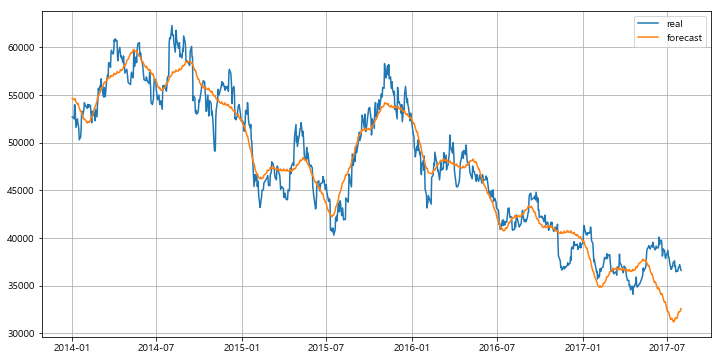

In [73]:
plt.figure(figsize=(12,6))
plt.plot(KIA.index, KIA['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

## Growth Model과 Holiday Forecast

In [75]:
df = pd.read_csv('../data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])

In [77]:
# 상한선
df['cap'] = 8.5

In [78]:
m = Prophet(growth='logistic', daily_seasonality=True)
m.fit(df)

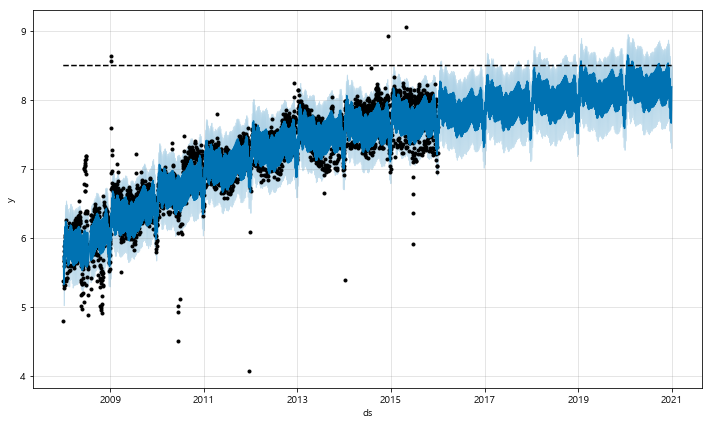

In [79]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst);

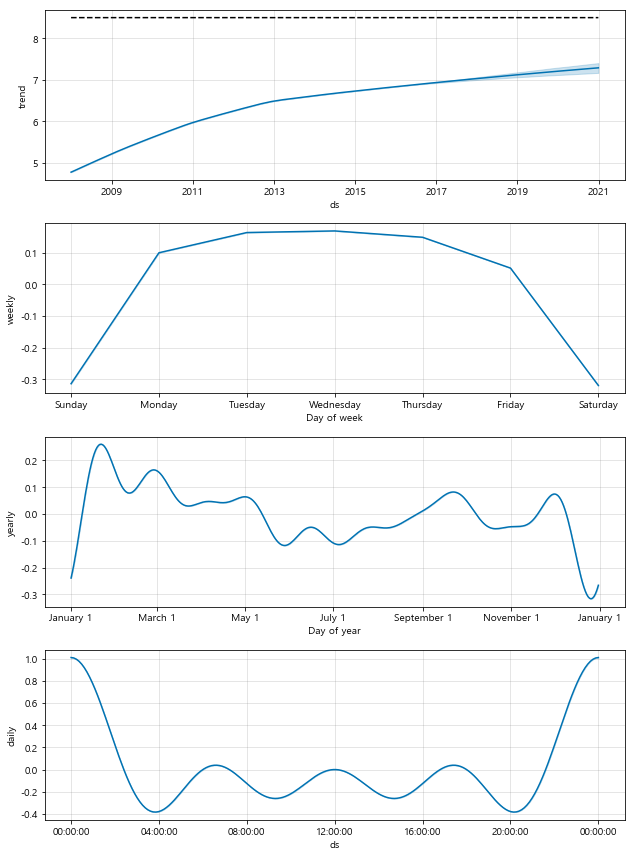

In [80]:
forecast = m.predict(future)
m.plot_components(forecast);

### holiday

In [81]:
df = pd.read_csv('../data/08. example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
m = Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=366)

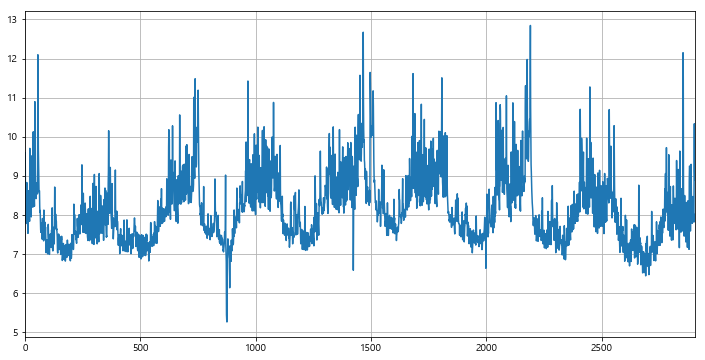

In [82]:
df.y.plot(figsize=(12,6), grid=True);

In [83]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [84]:
m = Prophet(holidays=holidays, daily_seasonality=True)
forecast = m.fit(df).predict(future)

In [85]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224221,1.194167
2191,2014-02-03,1.901795,1.480597
2532,2015-01-11,1.224221,0.000000
2533,2015-01-12,1.901795,0.000000
2901,2016-01-17,1.224221,0.000000
2902,2016-01-18,1.901795,0.000000
2908,2016-01-24,1.224221,0.000000
2909,2016-01-25,1.901795,0.000000
2922,2016-02-07,1.224221,1.194167
2923,2016-02-08,1.901795,1.480597


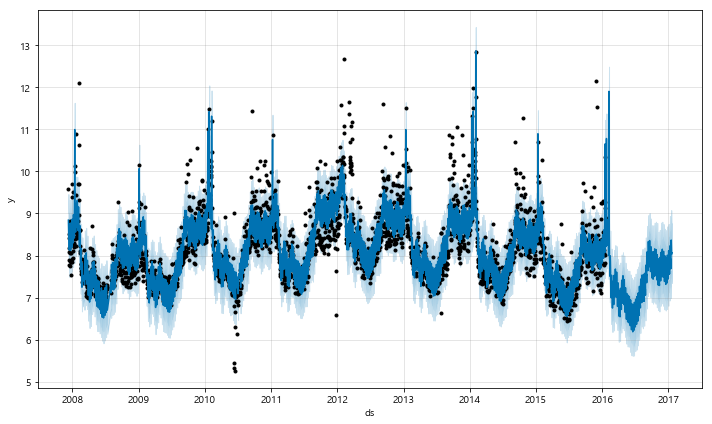

In [86]:
m.plot(forecast);

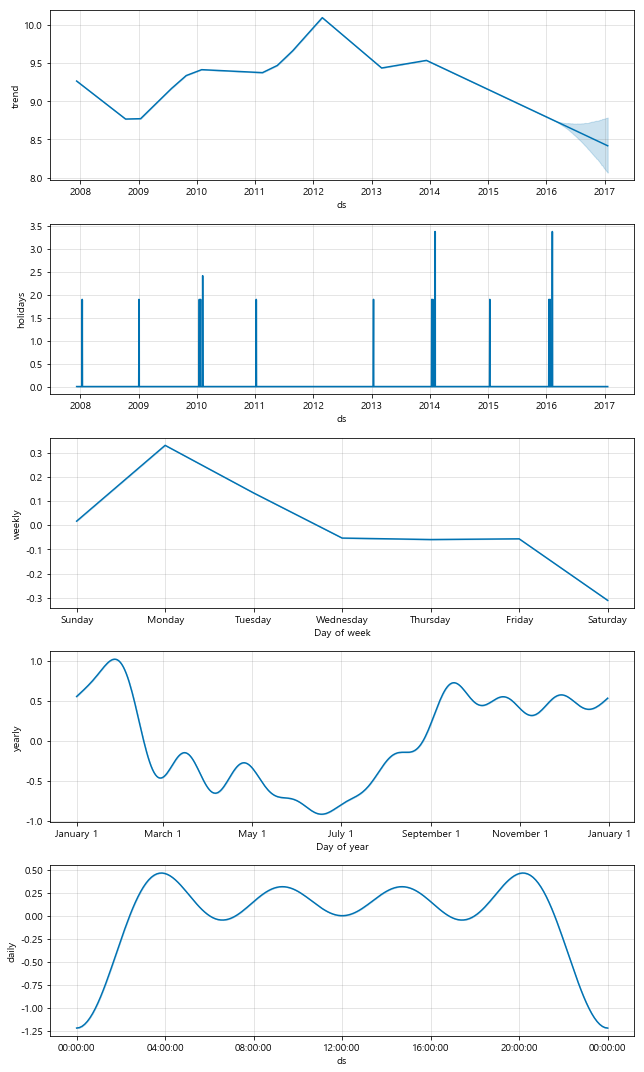

In [87]:
m.plot_components(forecast);